In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
df1 = pd.read_csv('../..coding/digiproject/BaSalam.products.csv', low_memory=False)

In [4]:
df2 = pd.read_csv('../..coding/digiproject/BaSalam.reviews.csv' , low_memory=False)

In [94]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list

In [95]:
# بررسی داده‌ها
print(f"تعداد کل نظرات: {len(df2)}")

تعداد کل نظرات: 3393574


In [96]:
# کاهش حجم داده برای تحلیل سریع‌تر
sample_size = min(10000, len(df2))  # حداکثر 10,000 نظر یا کمتر اگر داده‌ها کمتر باشند
df2_sample = df2.sample(sample_size, random_state=42)
print(f"تعداد نظرات نمونه: {len(df2_sample)}")

تعداد نظرات نمونه: 10000


In [97]:
# حذف نظرات خالی
df2_cleaned = df2_sample.dropna(subset=['description'])
print(f"تعداد نظرات پس از حذف موارد خالی: {len(df2_cleaned)}")

تعداد نظرات پس از حذف موارد خالی: 10000


In [98]:
# پیش‌پردازش متن فارسی - روش کامل
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stopwords = set(stopwords_list())

def preprocess_persian_text(text):
    if not isinstance(text, str):
        return ""
    
    # نرمال‌سازی متن
    text = normalizer.normalize(text)
    
    # حذف کاراکترهای غیر فارسی و اعداد
    text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)
    
    # حذف فاصله‌های اضافی
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [ ]:
# def advanced_preprocess_persian_text(text):
#     if not isinstance(text, str):
#         return ""
    
#     # نرمال‌سازی متن
#     text = normalizer.normalize(text)
    
#     # حذف کاراکترهای غیر فارسی و اعداد
#     text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)
    
#     # توکنایز کردن متن
#     words = word_tokenize(text)
    
#     # حذف استاپ وردها
#     words = [word for word in words if word not in stopwords]
    
#     # لماتیزیشن
#     words = [lemmatizer.lemmatize(word) for word in words]
    
#     # ترکیب مجدد متن
#     text = ' '.join(words)
    
#     return text

In [99]:
# اعمال پیش‌پردازش بر روی نظرات
print("در حال انجام پیش‌پردازش...")
# برای تست سریع‌تر از روش ساده استفاده می‌کنیم
df2_cleaned['processed_text'] = df2_cleaned['description'].apply(preprocess_persian_text)

در حال انجام پیش‌پردازش...


In [100]:
# حذف نظرات خالی پس از پیش‌پردازش
df2_cleaned = df2_cleaned[df2_cleaned['processed_text'] != ""]
print(f"تعداد نظرات پس از پیش‌پردازش: {len(df2_cleaned)}")

تعداد نظرات پس از پیش‌پردازش: 5847


In [101]:
# استخراج ویژگی با استفاده از TF-IDF - کاهش تعداد ویژگی‌ها
print("در حال استخراج ویژگی‌ها...")
vectorizer = TfidfVectorizer(max_features=500, min_df=5, max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(df2_cleaned['processed_text'])

در حال استخراج ویژگی‌ها...


In [102]:
# خوشه‌بندی با MiniBatchKMeans برای سرعت بیشتر
print("در حال انجام خوشه‌بندی...")
num_clusters = 3
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=100)
df2_cleaned['cluster'] = kmeans.fit_predict(tfidf_matrix)


در حال انجام خوشه‌بندی...


C:\Users\Zahra\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [103]:
# تحلیل خوشه‌ها برای شناسایی احساسات
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    feature_names = vectorizer.get_feature_names_out()
    
    cluster_features = {}
    for label in labels:
        ids_in_cluster = np.where(prediction == label)[0]
        if len(ids_in_cluster) == 0:
            continue
        mean_tfidf = np.array(tf_idf_array[ids_in_cluster].mean(axis=0)).reshape(-1)
        sorted_indices = mean_tfidf.argsort()[::-1]
        cluster_features[label] = [feature_names[idx] for idx in sorted_indices[:n_feats]]
    
    return cluster_features

In [104]:
# استخراج 10 کلمه کلیدی برتر هر خوشه
top_cluster_features = get_top_features_cluster(tfidf_matrix.toarray(), df2_cleaned['cluster'], 10)

# نمایش کلمات کلیدی هر خوشه
for cluster, features in top_cluster_features.items():
    print(f"\nکلمات کلیدی خوشه {cluster}:")
    print(", ".join(features))
    
    # نمایش 3 نظر نمونه از هر خوشه
    sample_reviews = df2_cleaned[df2_cleaned['cluster'] == cluster]['description'].sample(min(3, len(df2_cleaned[df2_cleaned['cluster'] == cluster]))).values
    print("\nنمونه نظرات:")
    for i, review in enumerate(sample_reviews):
        print(f"{i+1}. {review}")


کلمات کلیدی خوشه 0:
عالی, بود, بسیار, ممنون, خیلی, ممنونم, کیفیت, سلام, تشکر, واقعا

نمونه نظرات:
1. عالی بود 🌷
2. عالی
3. خیلی عالی بود

کلمات کلیدی خوشه 1:
از, خیلی, عالی, بود, ممنون, به, غرفه, دار, با, خوب

نمونه نظرات:
1. بسیارعالی وشیک
2. عالی بود مثل همیشه ممنون
3. کیفیت عالی بود اما ارسال خیلی طولانی شد فروشنده محترم یه خورده تغییر رویه بدید انشالله پر روزی باشید

کلمات کلیدی خوشه 2:
خوب, بود, خیلی, ممنون, ممنونم, بسیار, کیفیت, عالی, راضی, جنسش

نمونه نظرات:
1. خوب بود
2. خیلی خوب نمیپاکه
3. خوب بود


In [105]:
# کاهش ابعاد برای تجسم‌سازی خوشه‌ها
print("در حال آماده‌سازی تجسم‌سازی خوشه‌ها...")
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())
df2_vis = pd.DataFrame(reduced_features, columns=['x', 'y'])
df2_vis['cluster'] = df2_cleaned['cluster']

# تجسم‌سازی خوشه‌ها با استفاده از plotly
fig = px.scatter(
    df2_vis, x='x', y='y', color='cluster',
    title='تجسم‌سازی خوشه‌های احساسات',
    labels={'x': 'مؤلفه اصلی 1', 'y': 'مؤلفه اصلی 2', 'cluster': 'خوشه'}
)
fig.update_layout(
    width=900, 
    height=700, 
    template='plotly_white'
)
fig.show()

در حال آماده‌سازی تجسم‌سازی خوشه‌ها...


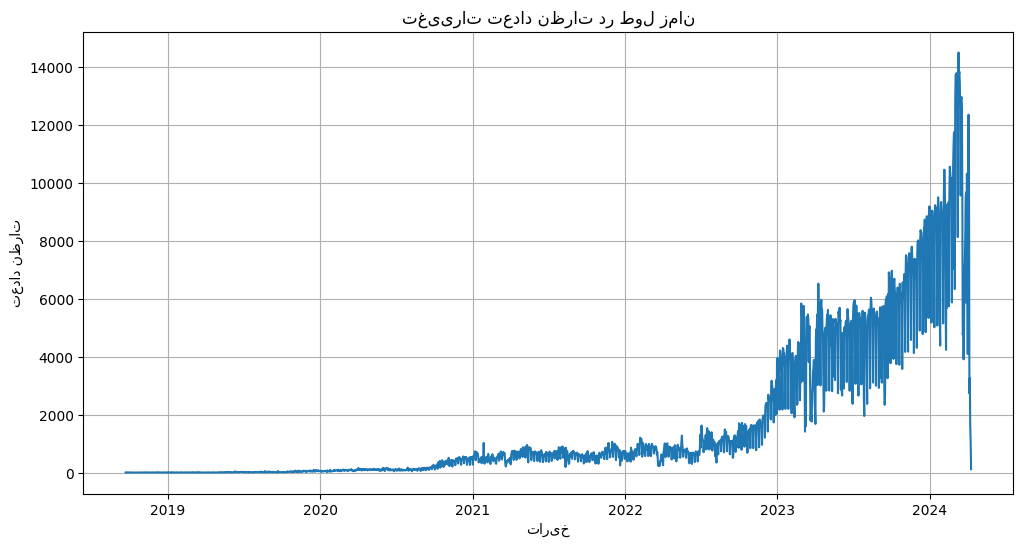

In [21]:
# تبدیل ستون تاریخ به فرمت datetime
df2['createdAt'] = pd.to_datetime(df2['createdAt'])

# استخراج تاریخ از ستون createdAt
df2['date'] = df2['createdAt'].dt.date

# گروه‌بندی بر اساس تاریخ و شمارش تعداد نظرات
daily_reviews = df2.groupby('date').size()

# نمایش نمودار تغییرات تعداد نظرات در طول زمان
plt.figure(figsize=(12, 6))
daily_reviews.plot()
plt.title('تغییرات تعداد نظرات در طول زمان')
plt.xlabel('تاریخ')
plt.ylabel('تعداد نظرات')
plt.grid(True)
plt.show()

In [23]:
# گروه‌بندی بر اساس دسته‌بندی و محاسبه مجموع فروش
category_sales = df1.groupby('categoryTitle')['sales_count_week'].sum().reset_index()

# مرتب‌سازی بر اساس مجموع فروش
category_sales = category_sales.sort_values(by='sales_count_week', ascending=False)

In [40]:
# انتخاب دسته‌های پر فروش و کم فروش
top_categories = category_sales.head(5)
bottom_categories = category_sales.tail(5)
selected_categories = pd.concat([top_categories, bottom_categories])

In [41]:
# رسم نمودار با Plotly
fig = px.bar(selected_categories, x='categoryTitle', y='sales_count_week',
             title='توزیع فروش در دسته‌های منتخب',
             labels={'sales_count_week': 'مجموع فروش هفتگی', 'categoryTitle': 'دسته‌بندی'},
             color='sales_count_week',
             color_continuous_scale='Blues')
fig.update_layout(xaxis_title='دسته‌بندی', yaxis_title='مجموع فروش هفتگی', xaxis_tickangle=-45)
fig.show()

In [43]:
# فیلتر کردن داده‌ها برای یک دسته‌بندی خاص
category = 'کتاب چاپی'  # به عنوان مثال
category_data = df1[df1['categoryTitle'] == category]

# گروه‌بندی بر اساس فروشنده و محاسبه مجموع فروش
vendor_sales = category_data.groupby('vendor_name')['sales_count_week'].sum().reset_index()

# مرتب‌سازی بر اساس مجموع فروش
vendor_sales = vendor_sales.sort_values(by='sales_count_week', ascending=False)

# نمایش فروشنده‌های برتر
top_vendors = vendor_sales.head(5)
print(top_vendors)

                 vendor_name  sales_count_week
761           کتابسرای مانگا               238
607         پخش کتاب دانشسرا               185
773  کتابفروشی بوکــــــشیـد               117
801                  کتابگاه                60
620                   پرینتل                57


In [46]:
from textblob import TextBlob


# انتخاب دسته‌بندی‌های خاص
selected_categories = ['کتاب چاپی', 'لوازم الکترونیکی']  # به عنوان مثال

# فیلتر کردن داده‌ها برای دسته‌بندی‌های خاص
filtered_df1 = df1[df1['categoryTitle'].isin(selected_categories)]
filtered_df2 = df2[df2['productId'].isin(filtered_df1['_id'])]

In [48]:
# تبدیل مقادیر غیر رشته‌ای به رشته و حذف مقادیر NaN
filtered_df2['description'] = filtered_df2['description'].fillna('').astype(str)
# تحلیل احساسات نظرات
filtered_df2['sentiment'] = filtered_df2['description'].apply(lambda x: TextBlob(x).sentiment.polarity)

C:\Users\Zahra\AppData\Local\Temp\ipykernel_35108\1961479981.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Zahra\AppData\Local\Temp\ipykernel_35108\1961479981.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
# محاسبه میانگین احساسات برای هر محصول
product_sentiment = df2.groupby('productId')['sentiment'].mean().reset_index()


In [56]:
# ادغام داده‌های فروش و احساسات
merged_data = pd.merge(df1, product_sentiment, left_on='_id', right_on='productId')

In [57]:
# محاسبه همبستگی
correlation = merged_data['sales_count_week'].corr(merged_data['sentiment'])
print(f'ضریب همبستگی بین احساسات و فروش در دسته‌بندی‌های انتخابی: {correlation}')

ضریب همبستگی بین احساسات و فروش در دسته‌بندی‌های انتخابی: 0.0009123545650880913


In [54]:
# تبدیل مقادیر غیر رشته‌ای به رشته و حذف مقادیر NaN
df2['description'] = df2['description'].fillna('').astype(str)
# تحلیل احساسات نظرات
df2['sentiment'] = df2['description'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [59]:
# محاسبه میانگین نمره احساسات و امتیاز برای هر محصول
product_metrics = df2.groupby('productId').agg({
    'sentiment': 'mean',
    'star': 'mean'
}).reset_index()

In [62]:
# ترکیب متریک‌ها (به عنوان مثال، میانگین ساده)
product_metrics['overall_satisfaction'] = (product_metrics['sentiment'] + product_metrics['star']) / 2

# نمایش نتایج
print(product_metrics.head())

   productId  sentiment      star  overall_satisfaction
0      20276        0.0  4.666667              2.333333
1      20400        0.0  4.540000              2.270000
2      20405        0.0  4.456522              2.228261
3      20459        0.0  4.777778              2.388889
4      20531        0.0  4.540000              2.270000


In [64]:
# فیلتر کردن ردیف‌هایی که مقدار sentiment بزرگتر از 0 است
positive_sentiment_products = product_metrics[product_metrics['sentiment'] > 0]

# نمایش نتایج
print(positive_sentiment_products)

        productId  sentiment      star  overall_satisfaction
89          25800   0.010000  4.840000              2.425000
256         33629   0.011905  4.785714              2.398810
291         34065   0.031250  4.812500              2.421875
337         34222   0.125000  4.750000              2.437500
409         35477   0.010000  4.700000              2.355000
...           ...        ...       ...                   ...
723969   13213338   0.500000  4.000000              2.250000
724561   13241066   0.250000  5.000000              2.625000
725093   13271364   0.500000  5.000000              2.750000
725749   13315289   0.500000  3.000000              1.750000
725750   13315344   0.500000  2.000000              1.250000

[2936 rows x 4 columns]


In [67]:
# ادغام دو دیتافریم بر اساس _id و productId
merged_df = pd.merge(df2, df1[['_id', 'categoryTitle', 'sales_count_week']], left_on='productId', right_on='_id', how='left')

In [68]:
# محاسبه مجموع فروش و میانگین احساسات برای هر دسته
category_analysis = merged_df.groupby('categoryTitle').agg({
    'sales_count_week': 'sum',
    'sentiment': 'mean'
}).reset_index()

In [76]:
# محاسبه میانگین و انحراف معیار
mean_sales = category_analysis['sales_count_week'].mean()
std_sales = category_analysis['sales_count_week'].std()

mean_sentiment = category_analysis['sentiment'].mean()
std_sentiment = category_analysis['sentiment'].std()

In [77]:
# شناسایی دسته‌های با پتانسیل بالا
high_potential_categories = category_analysis[
    (category_analysis['sales_count_week'] > mean_sales + std_sales) & 
    (category_analysis['sentiment'] > mean_sentiment + std_sentiment)
]

In [78]:
# شناسایی دسته‌های پرخطر
risky_categories = category_analysis[
    (category_analysis['sales_count_week'] < mean_sales - std_sales) & 
    (category_analysis['sentiment'] < mean_sentiment - std_sentiment)
]

In [79]:
print("دسته‌های با پتانسیل بالا:")
print(high_potential_categories)

print("دسته‌های پرخطر:")
print(risky_categories)

دسته‌های با پتانسیل بالا:
Empty DataFrame
Columns: [categoryTitle, sales_count_week, sentiment]
Index: []
دسته‌های پرخطر:
Empty DataFrame
Columns: [categoryTitle, sales_count_week, sentiment]
Index: []


In [80]:
# ادغام دو دیتافریم بر اساس _id و productId
merged_df = pd.merge(df2, df1[['_id', 'vendor_name', 'sales_count_week']], left_on='productId', right_on='_id', how='left')

In [81]:
# محاسبه مجموع فروش و میانگین احساسات برای هر فروشنده
vendor_analysis = merged_df.groupby('vendor_name').agg({
    'sales_count_week': 'sum',
    'sentiment': 'mean'
}).reset_index()

In [82]:
# محاسبه امتیاز فروشنده‌ها
# فرض می‌کنیم که وزن فروش 0.7 و وزن نظرات 0.3 است
vendor_analysis['score'] = (0.7 * vendor_analysis['sales_count_week']) + (0.3 * vendor_analysis['sentiment'])

In [84]:
# نمایش 10 فروشنده برتر به صورت جدول
print(vendor_analysis.sort_values(by='score', ascending=False).head(10))

                                        vendor_name  sales_count_week  \
3312                                   آرایشی افلاک             38118   
3688                        آرایشی هوتران (Hootran)             33738   
3007                          آجیل و خشکبار روستایی             26821   
26419                         فروشگاه بذر فردین کشت             22279   
26465  فروشگاه بزرگ اعتماد ( ارسال یک روزه با پیک )             15871   
34644                           محصولات پوستی سانیا             12915   
26484                       فروشگاه بزرگ سعیدی نژاد             11784   
16668                                      دومو بوک             10957   
34632                             محصولات پوست مهتا             10855   
26456                        فروشگاه برکت پیله چیان             10393   

       sentiment         score  
3312    0.000317  26682.600095  
3688    0.000225  23616.600068  
3007    0.000102  18774.700031  
26419   0.000063  15595.300019  
26465   0.000300  11109.700090 

In [86]:
# ایجاد نمودار میله‌ای با Plotly
fig = px.bar(top_vendors, x='score', y='vendor_name', orientation='h', 
             title='Top 10 Vendors by Score', labels={'score': 'Score', 'vendor_name': 'Vendor Name'},
             color='score', color_continuous_scale='Viridis')

# نمایش نمودار
fig.show()

In [87]:
# محاسبه ضریب همبستگی بین preparationDays و sales_count_week
correlation = df1['preparationDays'].corr(df1['sales_count_week'])

print(f'ضریب همبستگی بین زمان آماده‌سازی و فروش: {correlation}')

ضریب همبستگی بین زمان آماده‌سازی و فروش: -0.009329281222010936


In [88]:
# محاسبه میانگین و انحراف معیار فروش برای هر دسته
category_stats = df1.groupby('categoryTitle')['sales_count_week'].agg(['mean', 'std']).reset_index()


In [89]:
# ادغام آمار دسته‌ها با داده‌های اصلی
df1 = pd.merge(df1, category_stats, on='categoryTitle', how='left')

In [90]:
# شناسایی کالاهایی که فروش آن‌ها خارج از محدوده میانگین ± 2 انحراف معیار است
outliers = df1[(df1['sales_count_week'] > df1['mean'] + 2 * df1['std']) | 
               (df1['sales_count_week'] < df1['mean'] - 2 * df1['std'])]

In [93]:
# نمایش کالاهای با روند فروش متفاوت
print("کالاهایی که روند فروش آن‌ها با توزیع سایر کالاهای مشابه متفاوت است:")
print(outliers[['_id', 'categoryTitle', 'sales_count_week']])

کالاهایی که روند فروش آن‌ها با توزیع سایر کالاهای مشابه متفاوت است:
              _id              categoryTitle  sales_count_week
0         9873883                  میوه تازه                14
1           21808            روغن‌های خوراکی                13
2        10215970                  میوه تازه                12
3        11061637                      ادویه                11
4        10843522                  میوه تازه                11
...           ...                        ...               ...
2410458  13335507                   پاوربانک                 2
2410806   2095501       لوازم جانبی پاوربانک                 1
2410973   7895121        پخش‌کننده MP3 و MP4                 2
2411034  11461107              ضبط‌کننده صدا                 1
2411059  11217158  سایر لوازم الکتریکی همراه                 1

[60023 rows x 3 columns]
